# Store Sales - Time Series Forecasting

The evaluation metric is the Root Mean Squared Logarithmic Error 
$$RMSLE(\hat{y},y)=\sqrt{\frac{1}{n}\sum_{i=1}^n(\log(1+\hat{y}_i)-\log(1+y_i))^2}=RMSE\bigg(\log(1+\hat{y}),\log(1+y)\bigg)$$
For this reason we will take the target $z$ and transform it into a new target $y=\log(1+z)$. Then we will train our model to learn $y$ using as evaluation metric the RMSE, getting $\hat{y}$, then transform back as $\hat{z}=e^{\hat{y}}-1$

### Imports

In [159]:
import pandas as pd
from pathlib import Path
import numpy as np

from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque


### Utilities

In [ ]:
def autoregressive_forecast(model, df_model_test, features, lags=(1, 7, 14, 28)):
    """
    Perform day-by-day autoregressive forecasting.
    
    Parameters
    ----------
    model : trained model
        Model trained on log-transformed target (log1p(sales)).
    df_model_test : pd.DataFrame
        Test set containing lag features and other predictors.
    features : list
        List of feature column names used for prediction.
    lags : tuple of int
        Lag periods to update (default: (1, 7, 14, 28)).

    Returns
    -------
    pd.DataFrame
        Copy of df_model_test with columns:
        - 'pred': predicted log-sales
        - 'sales': predicted sales in original scale
        - updated lag features
    """

    df_pred = df_model_test.copy()
    df_pred['pred'] = np.nan
    test_dates = sorted(df_pred['date'].unique())
    key_cols = ['store_nbr', 'family']

    for date in test_dates:
        mask_day = df_pred['date'] == date
        X_day = df_pred.loc[mask_day, features].copy()

        preds = model.predict(X_day)
        df_pred.loc[mask_day, 'pred'] = preds

        # update lag features for future days
        for lag in lags:
            target_date = date + pd.Timedelta(days=lag)
            if target_date in df_pred['date'].values:
                mask_future = df_pred['date'] == target_date

                df_future = df_pred.loc[mask_future, key_cols]
                df_today = df_pred.loc[mask_day, key_cols].copy()
                df_today['pred_val'] = preds

                merged = pd.merge(df_future, df_today, on=key_cols, how='left')
                df_pred.loc[mask_future, f'sales_lag_{lag}'] = np.expm1(merged['pred_val'].values)

    df_pred['sales'] = np.expm1(df_pred['pred'])
    return df_pred


In [ ]:
# # 1) Build roll-forward frames with unique columns
# date_col = 'date'
# keys = ['store_nbr','family']           # grouping keys -> identify each time series
# sales_lag_cols = sorted([c for c in features if c.startswith('sales_lag_')],
#                         key=lambda c: int(c.split('_')[-1]))


# #cols_va = features + [date_col] + keys
# #X_va_rf = valid.loc[:, cols_va] # 
# # X_va_rf = X_va_rf.loc[:, ~X_va_rf.columns.duplicated()].copy() # dataset with validation rows and all the model features plus date and keys

# ############################
# cols_te = features + [date_col] + keys # (keys might appear in features but it doesn't matter) we will remove duplicates
# X_te_rf = df_model_test.loc[:, cols_te]
# X_te_rf = X_te_rf.loc[:, ~X_te_rf.columns.duplicated()].copy()
# ############################
# # 2) Use training feature set for inference, not the augmented columns
# feature_cols = features  # exactly what the model was trained on



# def roll_forward_predict(model, X_h, hist_df, keys, date_col, sales_lag_cols, feature_cols):
#     '''
#     - Model: the trained model
#     - X_h: dataset with validation/test rows and all the model features (icluding pre-existing sales_lag_* columns that will be overwritten) 
#       plus date and keys. Output will predict instances in this order
#     - hist_df: dataset with historical sales prior the horizon, column: keys + [date_col, 'sales']
#     - keys: list of column names that identify a series (i.e. ['store_nbr','family']). Must exist in both X_h and hist_df
#     - date_col: name of the column with dates
#     - sales_lag_cols: names of columns with lag sales
#     - feature_cols: the exact set of columns passed to the model at training time
    
#     RETURNS: pandas.Series of predictions on the log1p(sales) scale, indexed by X_h.index, so you can align directly to the input rows
    
#     '''

#     Xt = X_h.copy()
#     Xt[date_col] = pd.to_datetime(Xt[date_col])
#     hist = hist_df.copy()
#     hist[date_col] = pd.to_datetime(hist[date_col])

#     # label-indexed output to avoid positional errors
#     out = pd.Series(index=Xt.index, dtype=float)

#     Lmax = max(int(c.split('_')[-1]) for c in sales_lag_cols) # extracts the largest lag number (28), defines how many past sales values must be carried to compute all lag features.

#     dic = Xt.groupby(keys).groups # dictionary that associates each key=(store_nbr,family) to the indices of the rows of Xt corresponding to key
#     iteratable = dic.items() # iterator of (identifier_tuple, index_list) pairs.

#     for g, idx in iteratable: # g is (store_nbr,family), idx are the corresponding indices in the df 

#         # order this group's rows by date, keep labels
#         gidx = Xt.loc[idx].sort_values(date_col).index # it is just idx but in cronological order (probably already was)

#         # seed deque with true sales before first horizon date
#         t0 = Xt.loc[gidx[0], date_col] # first date to forecast in the ts
#         h = (hist[(hist[keys[0]]==g[0]) &
#                   (hist[keys[1]]==g[1]) &
#                   (hist[date_col] < t0)]  # ts before t0
#              .sort_values(date_col)['sales'].to_numpy())
#         dq = deque(h[-Lmax:].tolist(), maxlen=Lmax) # keeps only the last 28 days: dq is now the 28 days before t0

#         for ridx in gidx: # for every date in the time series
            
#             for c in sales_lag_cols: # for every lag value
#                 k = int(c.split('_')[-1]) # extracts the numeric value of the lag from the string name
#                 Xt.at[ridx, c] = dq[-k] if k <= len(dq) else np.nan # fills that column in the current row with the k-days-old sales value, or leaves it NaN if no enough hystory

#             yhat_log = model.predict(Xt.loc[[ridx], feature_cols])[0] # now the model has all the features to the prediction
#             out.at[ridx] = yhat_log # places the result in the output series
#             dq.append(np.expm1(yhat_log)) # appends the new value to the queue in the correct scale

#     return out  # Series aligned to X_h.index


# 4) Call it
# df_hist_val  = df_model_train[df_model_train['date'] <= cutoff][['store_nbr','family','date','sales']]
# pred_va_log  = roll_forward_predict(model, X_va_rf, df_hist_val, keys, date_col, sales_lag_cols, feature_cols)
# y_va already in log1p(sales) scale
#rmsle_val = np.sqrt(mean_squared_error(y_va.values, pred_va_log.values))
# print(f"Validation RMSLE (roll-forward): {rmsle_val:.5f}")

# df_hist_test = df_model_train[df_model_train['date'] < first_test_date][['store_nbr','family','date','sales']]
# pred_te_log  = roll_forward_predict(model, X_te_rf, df_hist_test, keys, date_col, sales_lag_cols, feature_cols)
# pred_test    = np.expm1(pred_te_log).values

### Data

In [160]:
PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
RAW_PATH = PROJECT_ROOT / "data" / "raw"

files = {
    "train": "train.csv",
    "test": "test.csv",
    "oil": "oil.csv",
    "holidays": "holidays_events.csv"
}

df_train, df_test, df_oil, df_holiday = [pd.read_csv(RAW_PATH / fname) for fname in files.values()]

## Feature engineering & Train/Val Split

In [161]:
# Add a column 'sales' to the test data frame (the target) filled with NaN. Now we can stack train and test together and easily compute the features for both
df_test['sales'] = pd.NA

# Fix datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Save the first date in the test set, so we will know how to split back
first_test_date = df_test['date'].min() # we will use it later for splitting train and test

# Concatenate the two dataset 
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)

# Change the type of the 'onpromotion' feature
df['onpromotion'] = df['onpromotion'].astype('float32') # important for speeding up training


/tmp/ipykernel_15442/3365020085.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df_train, df_test], ignore_index=True, sort=False)


#### Temporal features

In [162]:

# sort the df first for store number, than family product than date: all time series will be stacked
df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

# define lags for lagged features
lags = [1, 7, 14, 28]

# create a feature for each lag
for lag in lags:
    df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
    df[f'onpromo_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(lag)

# we add calendar features
df['dow'] = df['date'].dt.dayofweek # Day of the week (e.g. takes into account weekends)
df['dom'] = df['date'].dt.day # Number of the month (e.g. salaries are given twice a month)
df['month'] = df['date'].dt.month # Learns relevant month e.g. december for christmas
df[['dow','dom','month']] = df[['dow','dom','month']].astype('int16') 



#### Encode categories

In [163]:
# encode categorical
# IMPORTANT: train and validation as well as test contain the same categories so encoding now (before splitting) does not leak information
# We create a new feature containing encoded product family (cat 1, cat, 2 etc)
enc = OrdinalEncoder()
df['family_enc'] = enc.fit_transform(df[['family']]).astype('int16')

#### Taking into account earthquake event

In [164]:
# To make the model learn a decay effect after the earthquake event of April 16, 2016
# Adds a new column containing the number of days after the event
eq_day = '2016-04-16'
df['days_since_eq'] = (df['date'] - pd.Timestamp(eq_day)).dt.days
# reset to nan days before the earthquake to prevent a countdown and leak info
df.loc[df['days_since_eq'] < 0, 'days_since_eq'] = np.nan

#### Include oil prices

In [165]:
# Fix datetime format
df_oil['date'] = pd.to_datetime(df_oil['date'])
# Change the column name to a more readable one
df_oil = df_oil.rename(columns={'dcoilwtico': 'oil_price'})

# There are several days that:
#  - Are not listed in df_oil (holes)
#  - Are listed but the oil price is NaN

# We consider all the dates appearing in the original dataset 
all_dates = pd.DataFrame({'date': df['date'].dropna().unique()})

# and we add new rows to df_oil with the missing dates, setting price to NaN
df_oil = pd.merge(all_dates, df_oil, on='date', how='left').sort_values('date').reset_index(drop=True)
 
# Propagate forward the last observed price (the first value was NaN so it remains)
df_oil['oil_price'] = df_oil['oil_price'].ffill()

# We merge with the original dataset: now every date has the last observed oil price (except the first one)
df = pd.merge(df, df_oil, on='date', how='left')

# lag_7 oil price feature
df['oil_price_lag_7'] = df['oil_price'].shift(7)


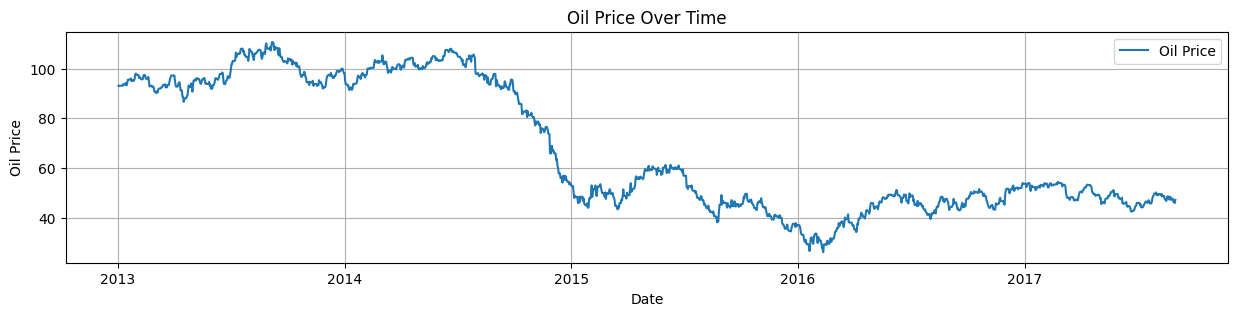

In [166]:
plt.figure(figsize=(15, 3))
plt.plot(df_oil['date'], df_oil['oil_price'], label='Oil Price')

plt.xlabel('Date')
plt.ylabel('Oil Price')
plt.title('Oil Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

### Choose features and prepare final dataset

In [167]:

# choose features
lag_cols = [c for c in df.columns if c.startswith(('sales_lag_', 'onpromo_lag_','oil_price_lag_'))]
base_cols = ['onpromotion','store_nbr','family_enc','dow','dom','month','days_since_eq','oil_price']

features = lag_cols  + base_cols


### Train/Validation/Test split

In [168]:
# we make a copy of the dataset
df_model = df.copy()

# Get train and test with engineered features
df_model_train = df_model[df_model['date'] < first_test_date].copy() #  -> this goes into the training set
df_model_test  = df_model[df_model['date'] >= first_test_date].copy() # -> this goes into the test set


df_model_test  = df_model[df_model['date'] >= first_test_date].copy() # -> this goes into the test set



# Log target for RMSLE: we add a new column to the train set with the transformed target
target = 'target'
df_model_train[target] = np.log1p(df_model_train['sales']) # We will use this transformed version of 'sales' as target

# Split train/validation
validation_days = 15 # set the number of days used for validation (set to 0 if predictions are on test)
cutoff = df_model_train['date'].max() - pd.Timedelta(days=validation_days) # we cut the last 15 days of the training set
train = df_model_train[df_model_train['date'] <= cutoff] # we split the training set in proper training... 
valid = df_model_train[df_model_train['date'] > cutoff] # ... and validation

X_tr, X_va = train[features], valid[features] # features for train and validation
y_tr, y_va = train[target],  valid[target] # target for train and validation




In [169]:
# There is at least one nan feature for the first 28 days. We remove those features.
# However we must keep the nan's in the 'days_since_eq' column
allowed_nan = ['days_since_eq']
mask_tr = X_tr.drop(columns=allowed_nan, errors='ignore').notna().all(axis=1)
X_tr, y_tr = X_tr[mask_tr], y_tr[mask_tr]


## Model

In [170]:

model = XGBRegressor(
    n_estimators=700,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=2.0,
    tree_method='hist',
    random_state=42,
    eval_metric='rmse'
)




In [171]:
model.fit(X_tr, y_tr, verbose=False)  


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


<Axes: ylabel='feature'>

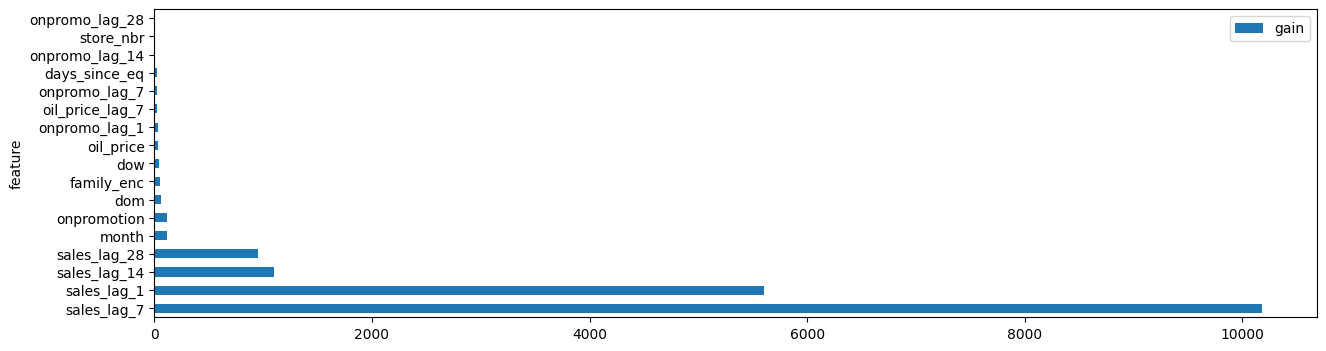

In [172]:
feat_names = X_tr.columns.tolist()
booster = model.get_booster()
score = booster.get_score(importance_type='gain')  # 'weight','gain','cover','total_gain','total_cover'
imp_gain = (pd.Series(score).rename_axis('feature')
            .reset_index(name='gain')
            .sort_values('gain', ascending=False))

# print(imp_gain.head(20))

imp_gain.head(30).plot(kind='barh', x='feature', y='gain', figsize=(15,4))


## Predictions validation

In [ ]:

# Assuming pred_test (raw-scale predictions) and df_test with an 'id' column exist
df_pred = autoregressive_forecast(model, valid, features, lags=(1, 7, 14, 28))
pred_test = df_pred.loc[valid.index, 'sales'].values


In [187]:
pred_test_log = np.log1p(pred_test)

rmsle_val = np.sqrt(mean_squared_error(y_va.values, pred_test_log))
print(f"Validation RMSLE (roll-forward): {rmsle_val:.5f}")

Validation RMSLE (roll-forward): 0.41385


###

In [ ]:
submission = pd.DataFrame({
    "id": df_model_test["id"],
    "sales": pred_test
})
submission = submission.sort_values('id').reset_index(drop=True)


submission.to_csv("submission.csv", index=False)
print("Saved:", submission.shape, "-> submission.csv")